`Prototype 초기화 방식 변경, temparture 변경, contrastive_weight 변경, Batch_size 변경, use_dim_reduction 변경`

Device: cuda
Loading UCI HAR Dataset from: C://Users/park9/CBAM_HAR/data
Loaded train data: X shape=(7352, 9, 128), y shape=(7352,)
Loaded test data: X shape=(2947, 9, 128), y shape=(2947,)
Train: 5881, Validation: 1471, Test: 2947
Calculating initial prototypes from mean features...
>>> [Temporary Model or No Init Provided] Prototypes initialized with Xavier Uniform.


Prototype Init: 100%|██████████| 58/58 [00:00<00:00, 115.99it/s]


Initial prototypes calculated. Shape: torch.Size([6, 64])

Training: + CBAM + CrossFormer + Contrast (Full + Mean Proto Init)
Config: {'use_cbam': True, 'use_crossformer': True, 'use_contrast': True, 'use_dim_reduction': False}
>>> [Main Model] Prototypes initialized with calculated mean features.
Parameters: 71,068


  Epoch [10/100] Loss: 0.1359 (CE: 0.1076, CT: 0.1131) | Val Acc: 0.9558


  Epoch [20/100] Loss: 0.1063 (CE: 0.0841, CT: 0.0888) | Val Acc: 0.9633


  Epoch [30/100] Loss: 0.0706 (CE: 0.0562, CT: 0.0579) | Val Acc: 0.9680


  Epoch [40/100] Loss: 0.0409 (CE: 0.0324, CT: 0.0343) | Val Acc: 0.9810


  Epoch [50/100] Loss: 0.0355 (CE: 0.0282, CT: 0.0292) | Val Acc: 0.9864


  Epoch [60/100] Loss: 0.0281 (CE: 0.0224, CT: 0.0228) | Val Acc: 0.9898


  Epoch [70/100] Loss: 0.0238 (CE: 0.0190, CT: 0.0194) | Val Acc: 0.9878


  Epoch [80/100] Loss: 0.0214 (CE: 0.0170, CT: 0.0175) | Val Acc: 0.9918


  Epoch [90/100] Loss: 0.0159 (CE: 0.0127, CT: 0.0130) | Val Acc: 0.9898


  Epoch [100/100] Loss: 0.0155 (CE: 0.0124, CT: 0.0125) | Val Acc: 0.9898

✓ + CBAM + CrossFormer + Contrast (Full + Mean Proto Init) Complete!
  Best Val Acc: 0.9918 @ epoch 80
  Final Test (Best-VAL ckpt): Acc=0.9667 | F1=0.9666

Classification Report
                    precision    recall  f1-score   support

           WALKING     0.9918    0.9758    0.9837       496
  WALKING_UPSTAIRS     0.9894    0.9894    0.9894       471
WALKING_DOWNSTAIRS     0.9721    0.9952    0.9835       420
           SITTING     0.9579    0.8798    0.9172       491
          STANDING     0.9078    0.9624    0.9343       532
            LAYING     0.9890    1.0000    0.9944       537

          accuracy                         0.9667      2947
         macro avg     0.9680    0.9671    0.9671      2947
      weighted avg     0.9673    0.9667    0.9666      2947


Normalized Confusion Matrix


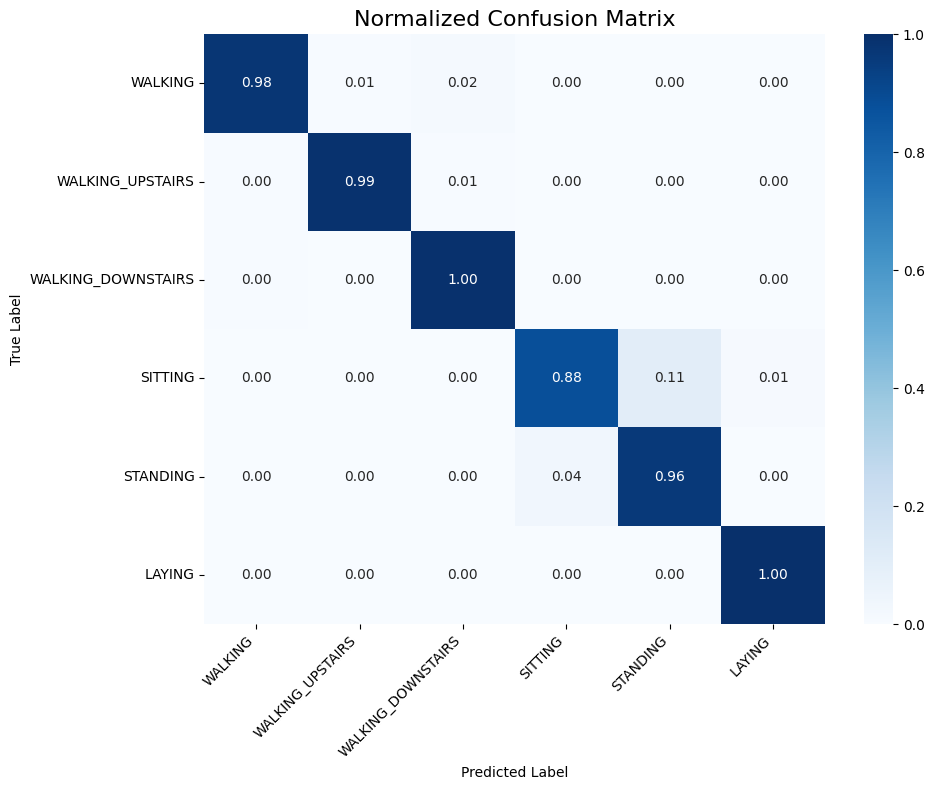


Generating t-SNE visualization...


Extracting features for t-SNE: 100%|██████████| 24/24 [00:00<00:00, 155.86it/s]


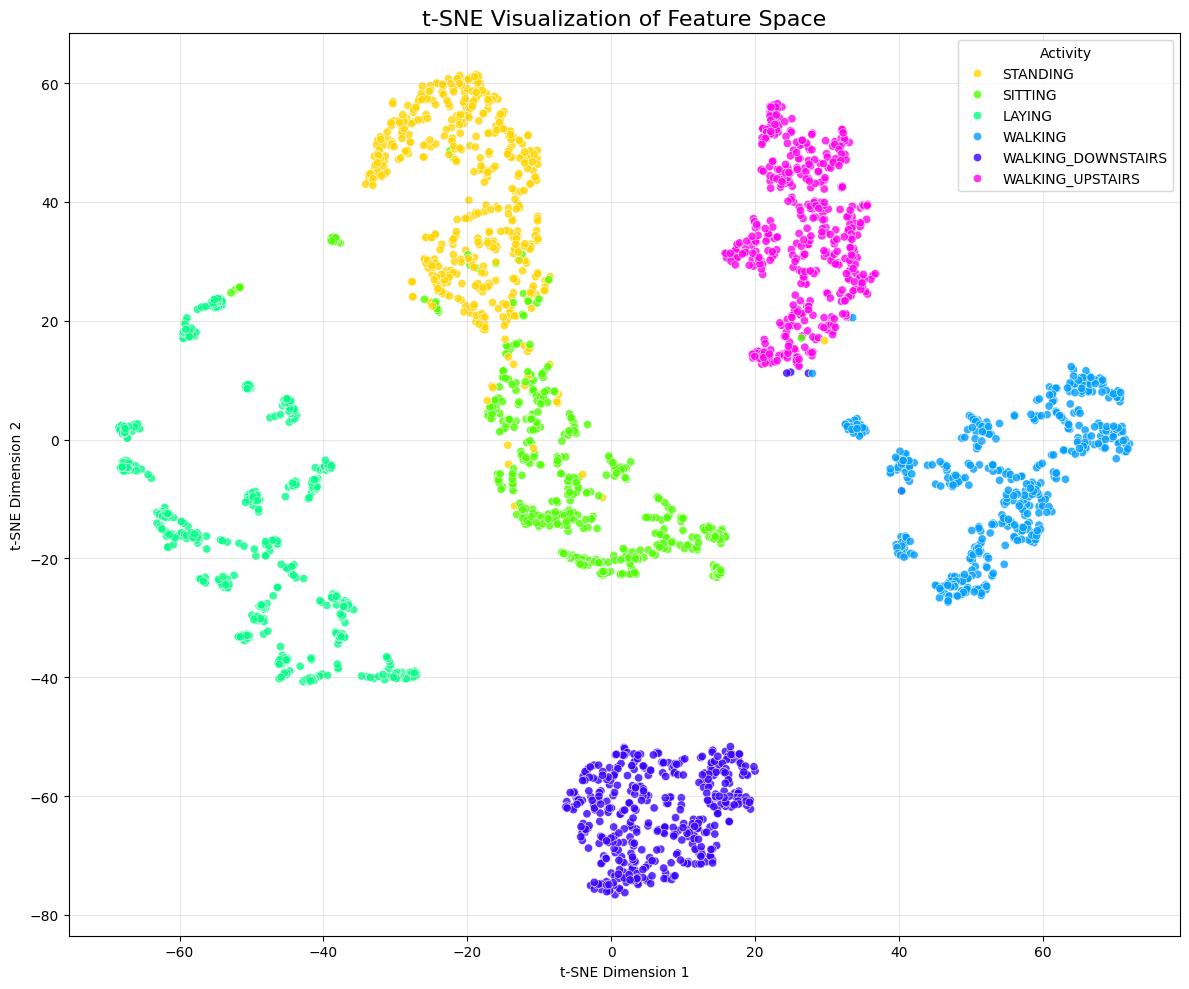


ALL PROCESSES COMPLETED!


In [1]:

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import os, copy
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import defaultdict
import random
from tqdm import tqdm

def seed_everything(seed=42):
    """
    재현성을 위해 Python, NumPy, PyTorch의 Seed를 고정합니다.
    """
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if use multi-GPU
    
    # cuDNN 설정 (재현성은 보장되나, 속도가 느려질 수 있음)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def seed_worker(worker_id):
    """
    DataLoader의 worker process를 위한 Seed 설정
    """
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

# =====================================================================
# 1. UCI HAR 데이터 로더
# =====================================================================
class UCIHARDataset(Dataset):
    def __init__(self, data_dir, train=True):
        """
        UCI HAR Dataset 로더
        data_dir: UCI HAR Dataset 폴더 경로
        train: True면 train 데이터, False면 test 데이터
        """
        subset = 'train' if train else 'test'

        # Inertial Signals 로드 (9개 센서)
        signals = []
        signal_types = [
            'body_acc_x', 'body_acc_y', 'body_acc_z',
            'body_gyro_x', 'body_gyro_y', 'body_gyro_z',
            'total_acc_x', 'total_acc_y', 'total_acc_z'
        ]

        for signal in signal_types:
            filename = os.path.join(data_dir, subset, 'Inertial Signals',
                                f'{signal}_{subset}.txt')
            # 1. 파일을 'r' (읽기) 모드로 직접 엽니다.
            with open(filename, 'r') as f:
                # 2. np.loadtxt에 파일 이름 대신 파일 객체(f)를 전달합니다.
                data = np.loadtxt(f)
                
            signals.append(data)

        # (N, 9, 128) 형태로 변환
        self.X = np.stack(signals, axis=1)

        # 레이블 로드 (1~6 -> 0~5로 변환)
        label_file = os.path.join(data_dir, subset, f'y_{subset}.txt')
        # 1. 파일을 'r' (읽기) 모드로 직접 엽니다.
        with open(label_file, 'r') as f:
            # 2. np.loadtxt에 파일 객체(f)를 전달합니다.
            self.y = np.loadtxt(f, dtype=np.int32) - 1

        print(f"Loaded {subset} data: X shape={self.X.shape}, y shape={self.y.shape}")

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return torch.FloatTensor(self.X[idx]), torch.LongTensor([self.y[idx]])[0]


# =====================================================================
# 2. 1D-CBAM (Channel + Temporal Attention)
# =====================================================================
class ChannelAttention1D(nn.Module):
    def __init__(self, channels, reduction=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.max_pool = nn.AdaptiveMaxPool1d(1)

        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # x: (B, C, T)
        avg_out = self.fc(self.avg_pool(x).squeeze(-1))  # (B, C)
        max_out = self.fc(self.max_pool(x).squeeze(-1))  # (B, C)
        out = self.sigmoid(avg_out + max_out).unsqueeze(-1)  # (B, C, 1)
        return x * out


class TemporalAttention1D(nn.Module):
    def __init__(self, kernel_size=7):
        super().__init__()
        self.conv = nn.Conv1d(2, 1, kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # x: (B, C, T)
        avg_out = torch.mean(x, dim=1, keepdim=True)  # (B, 1, T)
        max_out, _ = torch.max(x, dim=1, keepdim=True)  # (B, 1, T)
        out = torch.cat([avg_out, max_out], dim=1)  # (B, 2, T)
        out = self.sigmoid(self.conv(out))  # (B, 1, T)
        return x * out


class CBAM1D(nn.Module):
    def __init__(self, channels, reduction=16, kernel_size=7):
        super().__init__()
        self.channel_att = ChannelAttention1D(channels, reduction)
        self.temporal_att = TemporalAttention1D(kernel_size)

    def forward(self, x):
        x = self.channel_att(x)
        x = self.temporal_att(x)
        return x


# =====================================================================
# 3. Contrastive Prototype Loss
# =====================================================================
class ContrastivePrototypeLoss(nn.Module):
    def __init__(self, temperature=0.07):
        super().__init__()
        self.temperature = temperature

    def forward(self, features, prototypes, labels):
        """
        Contrastive Loss between features and prototypes

        Args:
            features: (B, D) - 샘플 특징
            prototypes: (N_class, D) - 클래스별 프로토타입
            labels: (B,) - 레이블

        Returns:
            loss: contrastive loss
        """
        # L2 정규화
        features = F.normalize(features, dim=1)
        prototypes = F.normalize(prototypes, dim=1)

        # 유사도 계산 (B, N_class)
        logits = torch.matmul(features, prototypes.t()) / self.temperature

        # InfoNCE Loss
        loss = F.cross_entropy(logits, labels)

        return loss


# =====================================================================
# 4. CrossFormer with Contrast Prototypes
# =====================================================================
class ContrastCrossFormerBlock(nn.Module):
    def __init__(self, dim, n_prototypes=6, n_heads=4, mlp_ratio=2.0, dropout=0.1,
                 initial_prototypes=None):
        super().__init__()
        self.dim = dim
        self.n_prototypes = n_prototypes
        self.n_heads = n_heads

        # Learnable prototypes (L2 정규화 적용)
        self.prototypes = nn.Parameter(torch.randn(n_prototypes, dim))

        # Xavier 초기화 대신, 전달받은 값으로 초기화 (없으면 Xavier 유지)
        if initial_prototypes is not None:
            assert initial_prototypes.shape == self.prototypes.shape, \
                f"Shape mismatch: initial_prototypes {initial_prototypes.shape} vs self.prototypes {self.prototypes.shape}"
            self.prototypes.data.copy_(initial_prototypes)
            print(">>> [Main Model] Prototypes initialized with calculated mean features.")
        else:
            nn.init.xavier_uniform_(self.prototypes)
            print(">>> [Temporary Model or No Init Provided] Prototypes initialized with Xavier Uniform.")

        # Cross-Attention: Input(Q) x Prototypes(K, V)
        self.norm1 = nn.LayerNorm(dim)
        self.cross_attn = nn.MultiheadAttention(dim, n_heads, dropout=dropout, batch_first=True)

        # Self-Attention
        self.norm2 = nn.LayerNorm(dim)
        self.self_attn = nn.MultiheadAttention(dim, n_heads, dropout=dropout, batch_first=True)

        # FFN
        self.norm3 = nn.LayerNorm(dim)
        hidden_dim = int(dim * mlp_ratio)
        self.mlp = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )

        # Prototype projection (contrastive learning용)
        self.proto_proj = nn.Sequential(
            nn.Linear(dim, dim),
            nn.GELU(),
            nn.Linear(dim, dim)
        )

    def forward(self, x, return_proto_features=False, skip_cross_attention=False):
        # x: (B, T, C)
        B, T, C = x.shape

        # 1. Cross-Attention (선택적 실행)
        if not skip_cross_attention:
            normalized_prototypes = F.normalize(self.prototypes, dim=1)
            prototypes = normalized_prototypes.unsqueeze(0).repeat(B, 1, 1).contiguous()
            x_norm = self.norm1(x)
            cross_out, attn_weights = self.cross_attn(x_norm, prototypes, prototypes)
            x = x + cross_out
        else: # Cross-Attention을 건너뛸 경우, attn_weights는 None
            attn_weights = None

        # 2. Self-Attention
        x_norm = self.norm2(x)
        self_out, _ = self.self_attn(x_norm, x_norm, x_norm)
        x = x + self_out

        # 3. FFN
        x = x + self.mlp(self.norm3(x))

        # Prototype features for contrastive loss
        if return_proto_features:
            # Global average pooling
            proto_features = x.mean(dim=1)  # (B, C)
            proto_features = self.proto_proj(proto_features)  # projection
            return x, proto_features, attn_weights

        return x


# =====================================================================
# 5. 메인 모델: CrossFormer + 1D-CBAM + Contrast Prototype
# =====================================================================
class ContrastCrossFormerCBAM_HAR(nn.Module):
    def __init__(self,
                 in_channels=9,
                 seq_len=128,
                 embed_dim=64,
                 reduced_dim=32,
                 n_classes=6,
                 n_prototypes=6,
                 n_heads=8,
                 dropout=0.1,
                 temperature=0.07,
                 initial_prototypes=None,
                 # Ablation 옵션
                 use_cbam=True,
                 use_crossformer=True,
                 use_contrast=True,
                 use_dim_reduction=False):
        super().__init__()

        self.in_channels = in_channels
        self.seq_len = seq_len
        self.embed_dim = embed_dim
        self.use_cbam = use_cbam
        self.use_crossformer = use_crossformer
        self.use_contrast = use_contrast
        self.use_dim_reduction = use_dim_reduction

        # 1. Input Embedding (1D Conv)
        self.embedding = nn.Sequential(
            nn.Conv1d(in_channels, embed_dim, kernel_size=11, padding=5),
            nn.BatchNorm1d(embed_dim),
            nn.GELU(),
            nn.Dropout(dropout)
        )

        # 2. CBAM (선택적)
        if self.use_cbam:
            self.cbam = CBAM1D(embed_dim, reduction=8, kernel_size=11)

        # 3. 차원 축소 (선택적)
        working_dim = reduced_dim if use_dim_reduction else embed_dim
        if self.use_dim_reduction:
            self.dim_reduce = nn.Linear(embed_dim, reduced_dim)

        # 4. CrossFormer Block (선택적)
        if self.use_crossformer:
            self.crossformer = ContrastCrossFormerBlock(
                dim=working_dim,
                n_prototypes=n_prototypes,
                n_heads=n_heads,
                mlp_ratio=2.0,
                dropout=dropout,
                initial_prototypes=initial_prototypes
            )
        else:
            # CrossFormer 없이 Self-Attention만 사용
            self.self_attn = nn.TransformerEncoderLayer(
                d_model=working_dim,
                nhead=n_heads,
                dim_feedforward=int(working_dim * 2),
                dropout=dropout,
                batch_first=True
            )

        # 5. 차원 복원 (선택적)
        if self.use_dim_reduction:
            self.dim_restore = nn.Linear(reduced_dim, embed_dim)

        # 6. Global Pooling + Classifier
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.classifier = nn.Sequential(
            nn.Linear(embed_dim, embed_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(embed_dim, n_classes)
        )

        # 7. Contrastive Loss (선택적)
        if self.use_contrast and self.use_crossformer:
            self.contrast_loss = ContrastivePrototypeLoss(temperature=temperature)

    def forward(self, x, labels=None, return_contrast_loss=False):
        # x: (B, C, T) = (B, 9, 128)

        # 1. Embedding
        x = self.embedding(x)  # (B, embed_dim, T)

        # 2. CBAM (선택적)
        if self.use_cbam:
            x = self.cbam(x)

        # 3. Reshape for Transformer
        x = x.transpose(1, 2).contiguous()  # (B, T, embed_dim)

        # 4. 차원 축소 (선택적)
        if self.use_dim_reduction:
            x = self.dim_reduce(x)

        # 5. CrossFormer 또는 Self-Attention
        proto_features = None
        attn_weights = None

        if self.use_crossformer:
            if return_contrast_loss and self.use_contrast:
                x, proto_features, attn_weights = self.crossformer(x, return_proto_features=True)
            else:
                x = self.crossformer(x, return_proto_features=False)
        else:
            x = self.self_attn(x)

        # 6. 차원 복원 (선택적)
        if self.use_dim_reduction:
            x = self.dim_restore(x)

        # 7. Pooling + Classification
        x = x.transpose(1, 2).contiguous()  # (B, embed_dim, T)
        x = self.pool(x).squeeze(-1)  # (B, embed_dim)
        logits = self.classifier(x)  # (B, n_classes)

        # Contrastive Loss 계산
        if return_contrast_loss and self.use_contrast and proto_features is not None and labels is not None:
            contrast_loss = self.contrast_loss(
                proto_features,
                self.crossformer.prototypes,
                labels
            )
            return logits, contrast_loss

        return logits

# =====================================================================
# 6. 평균 프로토타입 계산 함수
# =====================================================================
def get_mean_prototypes(train_full_dataset, device, embed_dim=64, 
                        reduced_dim=32, batch_size=128, use_dim_reduction=False):
    """
    훈련 데이터셋 전체를 사용하여 클래스별 평균 특징 벡터를 계산합니다.
    (Cross-Attention 제외하고 특징 추출)
    """
    print("Calculating initial prototypes from mean features...")

    # 1. 임시 특징 추출 모델 정의 (Embedding ~ Pooling까지만)
    #    (주의: 실제 모델 구조와 파라미터(dropout 등) 일치시킬 것)
    #    (여기서는 use_dim_reduction=False라고 가정)
    temp_model = ContrastCrossFormerCBAM_HAR(
        embed_dim=embed_dim, reduced_dim=reduced_dim, dropout=0.1, # Baseline 값 사용
        use_cbam=True, use_crossformer=True, use_contrast=False, # Contrast False로!
        use_dim_reduction=use_dim_reduction # 평균 계산 시 차원 축소 안 함
    ).to(device)
    temp_model.eval() # 평가 모드로 설정

    # 2. 전체 훈련 데이터 로더 (섞지 않음)
    temp_loader = DataLoader(train_full_dataset, batch_size=batch_size, shuffle=False)

    all_features = []
    all_labels = []

    # 3. 특징 추출 루프
    with torch.no_grad():
        for batch_x, batch_y in tqdm(temp_loader, desc="Prototype Init"):
            batch_x = batch_x.to(device)

            # --- 특징 추출 (ContrastCrossFormerCBAM_HAR의 forward 참고) ---
            # 1. Embedding
            x = temp_model.embedding(batch_x)
            # 2. CBAM
            if temp_model.use_cbam:
                x = temp_model.cbam(x)
            # 3. Reshape
            x = x.transpose(1, 2).contiguous()
            # 4. 차원 축소 
            if temp_model.use_dim_reduction:
                x = temp_model.dim_reduce(x)

            # 5. Self-Attention (CrossFormer 없이)
            # CrossFormer 블록을 호출하되, cross-attention 건너뛰기 옵션 활성화
            x = temp_model.crossformer(x, skip_cross_attention=True)

            # 6. 차원 복원 (여기서는 안 함)
            # 7. Pooling (Classifier 직전)
            x = x.transpose(1, 2).contiguous()
            pooled_features = temp_model.pool(x).squeeze(-1) # (B, embed_dim)
            # -----------------------------------------------------------

            all_features.append(pooled_features.cpu())
            all_labels.append(batch_y.cpu())

    all_features = torch.cat(all_features, dim=0)
    all_labels = torch.cat(all_labels, dim=0)

    # 4. 클래스별 평균 계산
    n_classes = temp_model.classifier[-1].out_features # 모델 정의에서 클래스 수 가져오기
    # ⬇️ 프로토타입 차원을 working_dim에 맞게 동적으로 설정
    working_dim = reduced_dim if use_dim_reduction else embed_dim
    mean_prototypes = torch.zeros(n_classes, working_dim)

    for i in range(n_classes):
        class_features = all_features[all_labels == i]
        if len(class_features) > 0:
            mean_prototypes[i] = class_features.mean(dim=0)
        else:
            print(f"Warning: No samples found for class {i} during prototype initialization.")
            # (샘플 없는 경우 랜덤 초기화 또는 0 벡터 사용 등 처리 필요)
            mean_prototypes[i] = torch.randn(working_dim) # 임시로 랜덤 사용

    print(f"Initial prototypes calculated. Shape: {mean_prototypes.shape}")
    return mean_prototypes.to(device) # GPU로 다시 보냄

# =====================================================================
# 7. 학습 및 평가 (Contrastive Loss 포함)
# =====================================================================
def train_epoch(model, dataloader, criterion, optimizer, device, use_contrast=True, contrast_weight=0.5):
    model.train()
    total_loss = 0
    total_ce_loss = 0
    total_contrast_loss = 0
    all_preds = []
    all_labels = []

    for batch_x, batch_y in tqdm(dataloader, desc="train", leave=False):
        batch_x, batch_y = batch_x.to(device, non_blocking=True), batch_y.to(device, non_blocking=True)

        optimizer.zero_grad()

        # Forward
        if use_contrast and model.use_contrast and model.use_crossformer:
            logits, contrast_loss = model(batch_x, batch_y, return_contrast_loss=True)
            ce_loss = criterion(logits, batch_y)
            loss = ce_loss + contrast_weight * contrast_loss
            total_contrast_loss += contrast_loss.item()
        else:
            logits = model(batch_x)
            ce_loss = criterion(logits, batch_y)
            loss = ce_loss

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_ce_loss += ce_loss.item()
        preds = logits.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch_y.cpu().numpy())
    
    torch.cuda.synchronize() # 한 에폭 끝에서 동기화

    avg_loss = total_loss / len(dataloader)
    avg_ce_loss = total_ce_loss / len(dataloader)
    avg_contrast_loss = total_contrast_loss / len(dataloader) if total_contrast_loss > 0 else 0
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')

    return avg_loss, avg_ce_loss, avg_contrast_loss, acc, f1


def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch_x, batch_y in dataloader:
            batch_x, batch_y = batch_x.to(device, non_blocking=True), batch_y.to(device, non_blocking=True)

            logits = model(batch_x)
            loss = criterion(logits, batch_y)

            total_loss += loss.item()
            preds = logits.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch_y.cpu().numpy())

    avg_loss = total_loss / len(dataloader)
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')

    return avg_loss, acc, f1, all_preds, all_labels

# =====================================================================
# 7. 시각화 
# =====================================================================

# 활동 레이블 정의 (그래프에 사용)
ACTIVITY_LABELS = [
    'WALKING',
    'WALKING_UPSTAIRS',
    'WALKING_DOWNSTAIRS',
    'SITTING',
    'STANDING',
    'LAYING'
]

def plot_training_history(history):
    """
    훈련 과정의 Loss와 Accuracy를 시각화합니다.
    Args:
        history (list of dicts): 에폭별 훈련/검증 결과가 담긴 리스트.
    """
    df = pd.DataFrame(history)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

    # Loss 곡선
    ax1.plot(df['epoch'], df['train_loss'], label='Train Loss')
    ax1.plot(df['epoch'], df['val_loss'], label='Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss', fontsize=16)
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Accuracy 곡선
    ax2.plot(df['epoch'], df['train_acc'], label='Train Accuracy')
    ax2.plot(df['epoch'], df['val_acc'], label='Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Training and Validation Accuracy', fontsize=16)
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def plot_classification_results(y_true, y_pred):
    """
    Classification Report를 출력하고, 정규화된 Confusion Matrix를 시각화합니다.
    Args:
        y_true (list or np.array): 실제 레이블.
        y_pred (list or np.array): 모델의 예측 레이블.
    """
    # 1. Classification Report 출력
    print("\n" + "="*80)
    print("Classification Report")
    print("="*80)
    print(classification_report(y_true, y_pred, target_names=ACTIVITY_LABELS, digits=4))

    # 2. 정규화된 Confusion Matrix 계산 및 시각화
    print("\n" + "="*80)
    print("Normalized Confusion Matrix")
    print("="*80)
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=ACTIVITY_LABELS, yticklabels=ACTIVITY_LABELS)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Normalized Confusion Matrix', fontsize=16)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

def visualize_tsne(model, dataloader, device):
    """
    학습된 모델을 사용하여 데이터의 특징을 t-SNE로 시각화합니다.
    Args:
        model: 학습이 완료된 모델.
        dataloader: 시각화할 데이터가 담긴 DataLoader (주로 test_loader).
        device: 'cuda' 또는 'cpu'.
    """
    print("\n" + "="*80)
    print("Generating t-SNE visualization...")
    print("="*80)

    model.eval()
    all_features = []
    all_labels = []

    with torch.no_grad():
        for batch_x, batch_y in tqdm(dataloader, desc="Extracting features for t-SNE"):
            batch_x = batch_x.to(device)

            # --- 최종 분류 레이어 직전의 특징 벡터 추출 ---
            x = model.embedding(batch_x)
            if model.use_cbam:
                x = model.cbam(x)
            x = x.transpose(1, 2)
            if model.use_dim_reduction:
                x = model.dim_reduce(x)
            
            x = model.crossformer(x, skip_cross_attention=False)
            
            if model.use_dim_reduction:
                x = model.dim_restore(x)

            pooled_features = x.mean(dim=1) # Global Average Pooling
            # -----------------------------------------------

            all_features.append(pooled_features.cpu().numpy())
            all_labels.append(batch_y.cpu().numpy())

    all_features = np.concatenate(all_features, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    # t-SNE 실행 (데이터가 많을 경우 시간이 소요될 수 있습니다)
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=2000, init='pca', learning_rate='auto')
    tsne_features = tsne.fit_transform(all_features)

    # 시각화
    df = pd.DataFrame(tsne_features, columns=['Dim1', 'Dim2'])
    df['label'] = [ACTIVITY_LABELS[l] for l in all_labels]

    plt.figure(figsize=(12, 10))
    sns.scatterplot(
        data=df,
        x='Dim1',
        y='Dim2',
        hue='label',
        palette=sns.color_palette("hsv", n_colors=len(ACTIVITY_LABELS)),
        legend="full",
        alpha=0.8
    )
    plt.title('t-SNE Visualization of Feature Space', fontsize=16)
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.legend(title='Activity')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# =====================================================================
# 8. 메인 실행
# =====================================================================
def main():
    # 하이퍼파라미터
    DATA_DIR = 'C://Users/park9/CBAM_HAR/data'
    BATCH_SIZE = 128  # 최소 256
    EPOCHS = 100  # 100으로 고정 
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    SEED = 42
    embed_dim = 64
    reduced_dim = 32
    seed_everything(SEED)

    print(f"Device: {DEVICE}")
    print(f"Loading UCI HAR Dataset from: {DATA_DIR}")

    # 데이터 로드
    train_full_dataset = UCIHARDataset(DATA_DIR, train=True)
    test_dataset = UCIHARDataset(DATA_DIR, train=False)

    # Train을 Train/Validation으로 분할 (80:20)
    train_size = int(0.8 * len(train_full_dataset))
    val_size = len(train_full_dataset) - train_size
    train_dataset, val_dataset = random_split(train_full_dataset, [train_size, val_size],
                                               generator=torch.Generator().manual_seed(SEED))

    print(f"Train: {len(train_dataset)}, Validation: {len(val_dataset)}, Test: {len(test_dataset)}")

    g = torch.Generator()
    g.manual_seed(SEED)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                              worker_init_fn=seed_worker, generator=g, num_workers=0, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False,
                            worker_init_fn=seed_worker, num_workers=0, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False,
                             worker_init_fn=seed_worker, num_workers=0, pin_memory=True)

    # Ablation Study 대신, "Full Model" 직접 생성 및 훈련/테스트
    config_name = "+ CBAM + CrossFormer + Contrast (Full + Mean Proto Init)"
    config_params = dict(use_cbam=True, use_crossformer=True, use_contrast=True, use_dim_reduction=False)

    # 평균 프로토타입 계산 (모델 생성 전)
    # (주의: embed_dim=64는 모델 생성 시 사용할 값과 일치해야 함)
    initial_prototypes = get_mean_prototypes(train_full_dataset, DEVICE, embed_dim=embed_dim, reduced_dim=reduced_dim,
                                             batch_size=BATCH_SIZE, use_dim_reduction=config_params['use_dim_reduction'])

    print("\n" + "="*80)
    print(f"Training: {config_name}")
    print(f"Config: {config_params}")
    print("="*80)

    # 모델 생성 시 initial_prototypes 전달
    model = ContrastCrossFormerCBAM_HAR(
        in_channels=9, seq_len=128, embed_dim=embed_dim, reduced_dim=reduced_dim,
        n_classes=6, n_prototypes=6, n_heads=8, dropout=0.1, temperature=0.05, # Baseline 값들
        initial_prototypes=initial_prototypes, # ⬅️ 계산된 값 전달
        **config_params
    ).to(DEVICE)

    total_params = sum(p.numel() for p in model.parameters())
    print(f"Parameters: {total_params:,}")

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=1e-4) # Baseline 옵티마이저
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

    # 학습 루프 (기존 run_ablation_study 내부 로직과 유사하게)
    best_val_acc = -1.0
    best_epoch = -1
    best_state = None
    for epoch in range(EPOCHS):
        train_loss, train_ce, train_contrast, train_acc, train_f1 = train_epoch(
            model, train_loader, criterion, optimizer, DEVICE,
            use_contrast=config_params['use_contrast'], contrast_weight=0.25 # Baseline contrast_weight
        )
        val_loss, val_acc, val_f1, _, _ = evaluate(model, val_loader, criterion, DEVICE)
        scheduler.step()
        torch.cuda.synchronize()  # GPU 작업 끝날 때까지 대기 → 로그가 제때 찍힘
        # print(f"[{epoch+1:03d}/{EPOCHS}] "
        #       f"train: loss={train_loss:.4f}, ce={train_ce:.4f}, ct={train_contrast:.4f}, "
        #       f"acc={train_acc:.4f}, f1={train_f1:.4f} | "
        #       f"val: loss={val_loss:.4f}, acc={val_acc:.4f}, f1={val_f1:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_epoch = epoch + 1
            best_state = copy.deepcopy(model.state_dict())

        if (epoch + 1) % 10 == 0:
             print(f"  Epoch [{epoch+1:2d}/{EPOCHS}] Loss: {train_loss:.4f} (CE: {train_ce:.4f}, CT: {train_contrast:.4f}) | Val Acc: {val_acc:.4f}")

    # 최종 테스트
    assert best_state is not None
    model.load_state_dict(best_state)
    test_loss, test_acc, test_f1, test_preds, test_labels = evaluate(model, test_loader, criterion, DEVICE)

    print(f"\n✓ {config_name} Complete!")
    print(f"  Best Val Acc: {best_val_acc:.4f} @ epoch {best_epoch}")
    print(f"  Final Test (Best-VAL ckpt): Acc={test_acc:.4f} | F1={test_f1:.4f}")

    # 5. 분류 결과 및 t-SNE 시각화
    plot_classification_results(test_labels, test_preds)
    visualize_tsne(model, test_loader, DEVICE)

    print("\n" + "="*80)
    print("ALL PROCESSES COMPLETED!")
    print("="*80)

if __name__ == '__main__':
    main()